# Machine Learning Models for Alzheimer's Classification

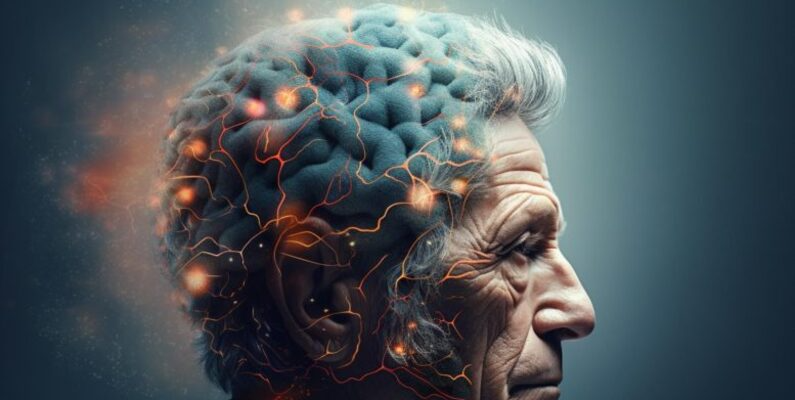

### Step 1: Introduction

**Alzheimer’s disease** is one of the most prevalent neurodegenerative disorders worldwide, affecting **millions of people** and posing a significant challenge to healthcare systems. As the global population ages, its incidence is expected to rise in the coming decades. **Early detection** is crucial to improving patients' quality of life and optimizing available treatments.

This project focuses on **developing and optimizing Machine Learning models for Alzheimer’s classification**, aiming to provide a supportive tool for medical professionals in disease screening. By applying feature selection techniques and hyperparameter tuning, the goal is to build an efficient and accurate model that can complement the diagnostic process or help confirm the results of other clinical tests.

### Step 2: Data loading and pre-processing

##### 2.1 Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

import xgboost as xgb
import lightgbm as lgb


# Path of the file where the functions are located and import it
sys.path.append(os.path.abspath('../'))
from utils.eda_functions import *
from utils.confusion_matrix import *

##### 2.2 Data loading and initial exploration.

In [2]:
# The initial df that has been downloaded from Kaggle is loaded with the information
route = "../data_sample/alzheimers_disease_data.csv"
df_alzheimer = pd.read_csv(route)

# Print the head of the df
print("First five lines of the dataset are the first five patients.\n")
df_alzheimer.head()

First five lines of the dataset are the first five patients.



,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid



The dataset has 2149 patients and 35 features of information about Alzheimer.

There are 1389 health patients and 760 patients diagnosed with Alzheimer's disease.


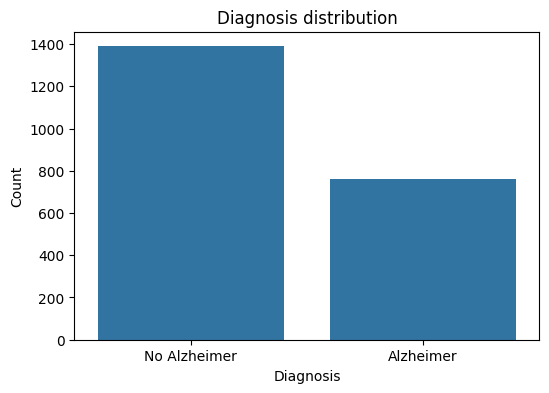

In [3]:
print(f"\nThe dataset has {df_alzheimer.shape[0]} patients and {df_alzheimer.shape[1]} features of information about Alzheimer.")

print(f"\nThere are {df_alzheimer[df_alzheimer.Diagnosis == 0].shape[0]} health patients and {df_alzheimer[df_alzheimer.Diagnosis == 1].shape[0]} patients diagnosed with Alzheimer's disease.")

# Plot the target of the dataset, that is Diagnosis
plt.figure(figsize=(6,4))
sns.countplot(x=df_alzheimer["Diagnosis"])

plt.title("Diagnosis distribution")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.xticks([0, 1], ["No Alzheimer", "Alzheimer"])
plt.show()

In [4]:
df_alzheimer["Diagnosis"].value_counts(normalize=True)

Diagnosis
0    0.646347
1    0.353653
Name: proportion, dtype: float64

As can be seen, the target is unbalanced, and it has to be taken into account in all the notebook (in model metrics, for example)

In [5]:
print("\nGeneral information of the dataset:\n")
df_alzheimer.info()


General information of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes  

In [6]:
df_alzheimer['DoctorInCharge'].value_counts()

DoctorInCharge
XXXConfid    2149
Name: count, dtype: int64

There are no null values in the dataset and all the features are numerical (float and int), except for the last one, which has the same value for all patients and will be removed at a later stage.

In [7]:
# Cardinality it's calculated in order to know if it's the index
car_id = cardinalidad(df_alzheimer["PatientID"], df_alzheimer)
print(f"The cardinality of the column containing the indices is of {car_id}%")

The cardinality of the column containing the indices is of 100.0%


It shows that 'PatientID' is the index of the dataset and there aren't duplicated patients in it.

##### 2.3 Feature description

Demographic factors:

| **Variable** | **Type** | **Description** |
| ---------------- | --------------- | ----------- |
| PatientID | int64 | Patient Index | | PatientID | int64 | PatientID | int64 | Patient Index |
| | Age | | int64 | Patient's age | | Gender | int64 | Gender
| Gender | int64 | Patient's gender, 0 or 1 | | | Ethnicity | int64 | Patient's gender, 0 or 1 |
| Patient's Ethnicity | int64 | Patient's Ethnicity, 0: Caucasian, 1: African American, 2: Asian, 3: Other |
| EducationLevel | int64 | Patient's educational level, 0: None, 1: High school, 2: Bachelor's degree, 3: College, 3: Higher education |

Lifestyle factors:

| **Variable** | **Type** | **Description** |
| ---------------- | --------------- | ----------- |
| BMI | float64 | Patient's body mass index, between 15-40 |
| Smoking | int64 | Whether or not the patient smokes, binary | | | AlcoholConsumption | float64 | float64 | BMI | Body Mass Index of the patient, between 15-40
| AlcoholConsumption | float64 | Patient's weekly alcohol consumption in units, 0-20 | | PhysicalActivity | float64 | float64 | BMI | BMI | BMI, between 15-40
| PhysicalActivity | float64 | Physical activity in patient hours, 0-10 | DietQuality | float64 | DietQuality | float64 | DietQuality | float64 | DietQuality
| SleepQuality | float64 | Patient's SleepQuality | float64 | Patient's Sleep Quality, 4-10 |

Medical history:

| **Variable** | **Type** | **Description** | 
| ---------------- | --------------- | ----------- |
| FamilyHistoryAlzheimers | int64 | If patient has a family history of Alzheimer's, binary | 
| CardiovascularDisease | int64 | If patient has a family history of Alzheimer's, binary |
| Diabetes | int64 | If patient has Alzheimer's disease, binary | 
| Depression | int64 | If the patient has diabetes, binary | 
| HeadInjury | int64 | If the patient has head injury or not, binary | 
| Hypertension | int64 | If the patient has head injury or not, binary | |


Clinical measurements:

| **Variable** | **Type** | **Description** |
| ---------------- | --------------- | ----------- |
| SystolicBP | int64 | Patient's systolic blood pressure, 90-180 mmHg. | 
| DiastolicBP | int64 | Patient's diastolic blood pressure, 60-120 mmHg. | 
| CholesterolTotal | float64 | Patient's total cholesterol levels, 150-300 mg/dL. | 
| CholesterolLDL | float64 | Patient's low-density lipoprotein cholesterol levels, 50-200 mg/dL. | 
| CholesterolHDL | float64 | High-density lipoprotein cholesterol levels, 20-100 mg/dL | 
| CholesterolTriglycerides | float64 | Patient's triglyceride levels, 50-400 mg/dL. | |

Cognitive and functional assessments:

| **Variable** | **Type** | **Description** |
| ---------------- | --------------- | ----------- |
| MMSE | float64 | Mini-Mental State Examination score, 0-30. |
| FunctionalAssessment | float64 | Functional Assessment Score, 0-10 | 
| MemoryComplaints | Int64 | Patient Memory Complaints, binary. |
| BehaviouralProblems | int64 | Patient Behavioural Problems, binary. |
| ADL | float64 | Activities of Daily Living Score, 0-10. | |

Symptoms:

| **Variable** | **Type** | **Description** | 
| ---------------- | --------------- | ----------- |
| Confusion | int64 | Behavioural problems of the patient, binary. |
| Disorientation | int64 | Disorientation of the patient, binary. |
| PersonalityChanges | int64 | Patient's personality changes, binary. |
| DifficultyCompletingTasks | int64 | DifficultyCompletingTasks of the patient, binary. |
| Forgetfulness | int64 | Patient forgetfulness, binary. |


Diagnosis: 

| **Variable** | **Type** | **Description** | 
| ---------------- | --------------- | ----------- |
| Diagnosis | int64 | Alzheimer's diagnosis of the patient, binary. Target | | **Target |
| DoctorInCharge | object | Doctor's information, confidential. |

In [8]:
df_alzheimer.nunique()

PatientID                    2149
Age                            31
Gender                          2
Ethnicity                       4
EducationLevel                  4
BMI                          2149
Smoking                         2
AlcoholConsumption           2149
PhysicalActivity             2149
DietQuality                  2149
SleepQuality                 2149
FamilyHistoryAlzheimers         2
CardiovascularDisease           2
Diabetes                        2
Depression                      2
HeadInjury                      2
Hypertension                    2
SystolicBP                     90
DiastolicBP                    60
CholesterolTotal             2149
CholesterolLDL               2149
CholesterolHDL               2149
CholesterolTriglycerides     2149
MMSE                         2149
FunctionalAssessment         2149
MemoryComplaints                2
BehavioralProblems              2
ADL                          2149
Confusion                       2
Disorientation

##### 2.4 Column cleaning, nulls and duplicates

**Missings**

In this case, as we have seen with the information previously, there are no nulls in any column. In the event that there were, it would be necessary to see in what proportion and how to solve it according to this: eliminate them, transform them by other values (mean, mode, median, etc)...

**Duplicates**

As assumed when teaching index cardinality, there are no duplicate patients. If there were, they should be removed by `drop_duplicates()`.

**Index and drop unnecessary features**

Set PatientID as index and clean the DoctorInChargeColumn

In [9]:
df_alzheimer.set_index("PatientID", inplace = True)

df_alzheimer.drop(columns = ["DoctorInCharge"], inplace = True)

print(f"The new feature number is {df_alzheimer.shape[1]}")


The new feature number is 33


**Transformations**

As we are not going to go that deep, we are going to transform the systolic and diastolic blood pressure into a single variable, mean arterial pressure (MAP). This is possible because they follow the following formula:

$$
MAP = \frac{P_{systolic} + 2 \cdot P_{dyastolic}}{3} mmHg
$$

In [10]:
df_alzheimer["MAP"] = (df_alzheimer["SystolicBP"] + (2*df_alzheimer["DiastolicBP"]))/3
df_alzheimer.drop(columns = ["SystolicBP", "DiastolicBP"], inplace = True)
print(f"The new feature number is {df_alzheimer.shape[1]}")

The new feature number is 32


##### 2.5 Feature treatment

The description of the numerics is observed to see if any need to be emphasised and to detect outliers (apply logarithms, etc.).

In [11]:
df_alzheimer.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,0.288506,0.453173,0.000000,0.000000,0.000000,1.000000,1.000000
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346
SleepQuality,2149.0,7.051081,1.763573,4.002629,5.482997,7.115646,8.562521,9.999840


No outliers are observed, however, in order to control for extreme values, a standardisation of the numerical features will be made.

**Numerical features**

Numerical variables have to be scaled for the best performance of some models, and although there are no outliers, to avoid the possible effects of extreme values.

In [12]:
# Define binary columns - NO SCALE
binary_cols = ["Gender", "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease", 
               "Diabetes", "Depression", "HeadInjury", "Hypertension", "MemoryComplaints", 
               "BehavioralProblems", "Confusion", "Disorientation", "PersonalityChanges", 
               "DifficultyCompletingTasks", "Forgetfulness", "Diagnosis"]

# Select the numerical ones
numeric_cols = df_alzheimer.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col not in binary_cols]

# Scale
scaler = StandardScaler()
df_alzheimer[numeric_cols] = scaler.fit_transform(df_alzheimer[numeric_cols])


**Categorical features**

The ethnicity and education level variables have 4 different values, so we do one-hot encoding, as linear models need it.

In [13]:
# Select columns
categorical_cols = ["Ethnicity", "EducationLevel"]

# Apply One-Hot Encoding 
df_alzheimer = pd.get_dummies(df_alzheimer, columns=categorical_cols, drop_first=True)

### Step 3: Split data in train/test

The target of the data is ‘Diagnosis’, which will be the y, and the X will be the rest of the features. We split 80% of the data for training and 20% for testing.

In [14]:
X = df_alzheimer.drop(columns=["Diagnosis"])  # avoiding target
y = df_alzheimer["Diagnosis"]  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Prove that the ratio in train and test is maintained.

In [15]:
print(f"The proportion of target in train is\n{y_train.value_counts(normalize=True)}")
print(f"\nThe proportion of target in test is\n{y_test.value_counts(normalize=True)}")

The proportion of target in train is
Diagnosis
0    0.646306
1    0.353694
Name: proportion, dtype: float64

The proportion of target in test is
Diagnosis
0    0.646512
1    0.353488
Name: proportion, dtype: float64


### Step 4: Base model training

**Metrics**

As we are detecting the diagnosis of a disease (we do not want false negatives) and we also have a somewhat unbalanced target, the following metrics will be used:

* F1-Score: Used because it combines precision and recall, useful in unbalanced data.
* Recall: Focuses on minimising false negatives, important for detecting the disease correctly.

**Models**.

The six models to be tested as a basis are:

* Logistic Regression (LR): Simple linear model that works well on datasets with direct relationships between variables and the target.
* Random Forest (RF): Tree-based ensemble algorithm, robust and good at capturing non-linear relationships.
* Support Vector Machine (SVM): Works well in high-dimensional spaces and is effective with non-linear data.
* K-Nearest Neighbors (KNN): Based on data proximity, useful when there is no clear structure.
* XGBoost: Boosting-based model, powerful for complex problems and improves performance by minimising errors from previous models.
* LightGBM: Boosting variant optimised for efficiency and speed on large datasets.

In [16]:
# Define base models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier()
}

In [17]:
# Train and evaluate models
results = []

for name, model in models.items():
    
    # train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results.append((name, f1, recall))

    # Show classification report
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

# Results in a df and order their f1 score
results_df = pd.DataFrame(results, columns=["Model", "F1-Score", "Recall"])
results_df = results_df.sort_values(by="F1-Score", ascending=False)

# Results
print("\nResults of base models:")
print(results_df)

# Top 3 in one variable
top_3_models = results_df.head(3)


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       278
           1       0.75      0.76      0.75       152

    accuracy                           0.83       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.83      0.83      0.83       430


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       278
           1       0.94      0.88      0.91       152

    accuracy                           0.94       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.94      0.94       430


Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       278
           1       0.83      0.71      0.77       152

    accuracy                           0.85       430
   

As can be seen, the three best performing models in the above metrics are LightGBM, XGBoost and Random Forest. Therefore, we focus the search for the best hyperparameters on LightGBM, that is the top 1.

### Step 5: Hyperparameter definition.

Search through **GridSearch** for the best hyperparameters of the best model previously obtained (LightGBM) to see how much it can be improved.

In [18]:
# Define the hyperparameters

param_grid = {
    "LightGBM": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [-1, 10, 20]
    }
}

In [19]:
# Train this model in order to extract the best hyperparameters
best_models = {}
best_params = {}

model_name = "LightGBM"
model = lgb.LGBMClassifier()

# Use GridSearch with cross val
grid_search = GridSearchCV(model, param_grid[model_name], 
                           scoring="recall", cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Save the model and the hyperparameters
best_models[model_name] = grid_search.best_estimator_
best_params[model_name] = grid_search.best_params_
    
print(f"\nBest configuration for {model_name}: {grid_search.best_params_}")
print(f"\nBest F1-score in cross-validation: {grid_search.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Then, with the best hyperparameters for LightGBM, tests should be done to see the results that it offers.

In [20]:
best_lgb = lgb.LGBMClassifier(**best_params['LightGBM'])
best_lgb.fit(X_train, y_train)
y_pred_lgb = best_lgb.predict(X_test)

print("LightGBM - Classification Report")
print(classification_report(y_test, y_pred_lgb))
print(f"F1 Score: {f1_score(y_test, y_pred_lgb)}")


[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

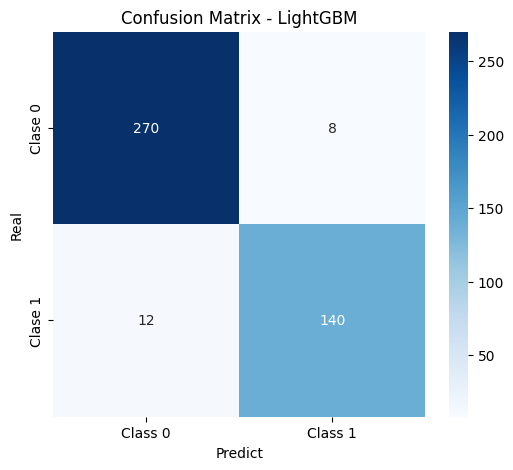

In [21]:
plot_confusion_matrix(y_test, y_pred_lgb, "LightGBM")

### Step 6: Feature selection

Although the model has an F1-score of 93.33%, feature selection is still beneficial as it can **reduce dimensionality** and **improve efficiency** without compromising performance. Additionally, it helps **decrease the risk of overfitting** by removing irrelevant features that may introduce noise. It also enhances model interpretability, making it easier to identify the most important variables. Finally, it allows for evaluating whether performance remains stable or even improves with a more optimized dataset.

* Using Random Forest model

It measures the importance of each variable, allowing the removal of irrelevant ones. Additionally, it is robust against complex and noisy data. 

In [22]:
# Train RF Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# feature importance
feature_importances = rf.feature_importances_

# features higher than threshold
threshold = 0.025
selected_features = X_train.columns[feature_importances > threshold]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"{len(selected_features)} selected features: {list(selected_features)}")

16 selected features: ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'MAP']


C:\Users\tebar\AppData\Local\Temp\ipykernel_14508\2796703077.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp_df, x="Importance", y="Feature", palette="viridis")


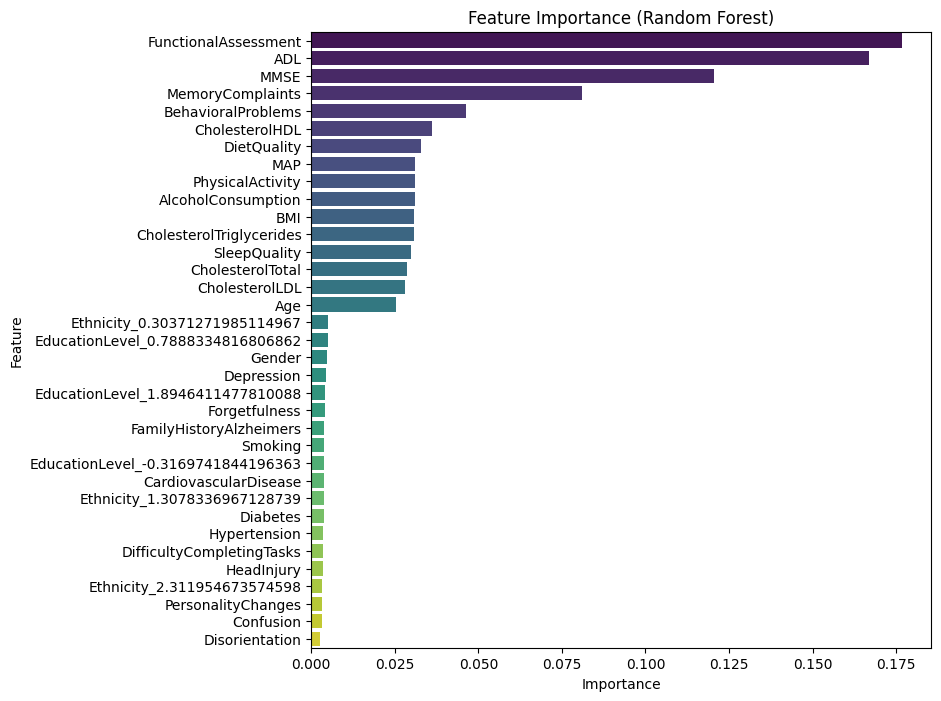

In [23]:
# Plot this features and their importance
feature_imp_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})
feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(data=feature_imp_df, x="Importance", y="Feature", palette="viridis")

plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

With this features, we train the LightGBM base model to see the results.

[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3279
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
LightGBM - F1 Score: 0.9333333333333333


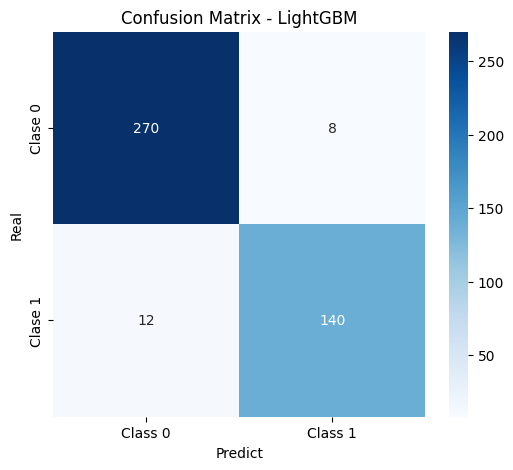

In [24]:
model = lgb.LGBMClassifier()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
print(f"LightGBM - F1 Score: {f1_score(y_test, y_pred)}")

plot_confusion_matrix(y_test, y_pred, "LightGBM")


Then, we train LightGBM with the best hyperparameters and the features selected by RF.

[LightGBM] [Info] Number of positive: 608, number of negative: 1111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3279
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353694 -> initscore=-0.602841
[LightGBM] [Info] Start training from score -0.602841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

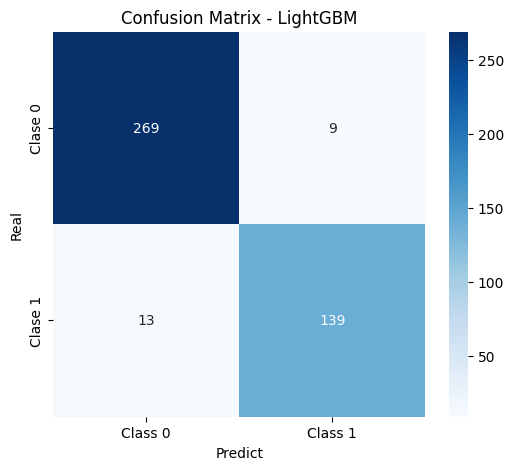

In [26]:
# Train model with best LightGBM hyperparameters
best_model = best_lgb
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)
print(f"LightGBM - F1 Score: {f1_score(y_test, y_pred)}")

plot_confusion_matrix(y_test, y_pred, "LightGBM")
